In [11]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [12]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

In [13]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [89]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'alarm.bif'))
true_dgm.draw()

In [15]:
data = true_dgm.rvs(size=1000)

In [16]:
gm.information.discrete_entropy(data[['VENTTUBE']])

0.75499557918174731

In [17]:
bic = gm.ScoreBIC(gm.MatrixGraph.from_networkx_DiGraph(true_dgm), data)

In [18]:
idx1 = list(data.columns).index('DISCONNECT')
idx2 = list(data.columns).index('VENTTUBE')
idx1, idx2

(1, 15)

In [19]:
vec = [False] * 37
vec[idx1] = True
bic(idx2, vec)

130.9952708712301

In [20]:
def entropy_stddev(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    for i in range(100):
        data = factor.rvs(n)
        results.append(gm.information.discrete_entropy(data))
    return np.std(results)

In [21]:
def dirichlet_variance(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    counts = n*factor.table.flatten()
    sum_counts = np.sum(counts)
    results = []
    for count in counts:
        results.append(n * (count * (sum_counts - count) / (sum_counts**2 * (sum_counts + 1))))
    return results
    
dirichlet_variance(1000, ['DISCONNECT', 'VENTTUBE'])

[0.083145896528015961,
 0.00099800199901463218,
 0.0063290176124113787,
 0.00099800199376766222,
 0.090376482247595494,
 0.195500586042961,
 0.0089100899185391037,
 0.054037039288968004]

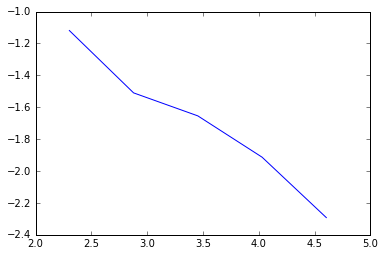

In [22]:
x = np.logspace(1, 2, num=5)
y = [np.log(entropy_stddev(n, ['DISCONNECT', 'VENTTUBE'])) for n in x]
plt.plot(np.log(x), y)

In [23]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.log(x).reshape(-1, 1), y)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from .murmurhash import murmurhash3_32
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.broadcast size changed, may indicate binary incompatibility
  from .murmurhash import murmurhash3_32
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.broadcast size changed, may indicate binary incompatibility
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from .sparsefuncs_fast import csr_row_norms
/usr/local/li

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
def entropy_std(n, p):
    p_mle = np.random.binomial(n, p, size=100000).astype('float') / n
    p_mle = np.maximum(np.minimum(p_mle, 1 - 1e-5), 1e-5)
    entropy_mle = -(p_mle * np.log(p_mle) + (1 - p_mle)*np.log(1 - p_mle))
    return np.std(entropy_mle)

In [25]:
entropy_std(10000, 0.3)

0.0038697977318989203

[  1.00000000e+01   1.20679264e+01   1.45634848e+01   1.75751062e+01
   2.12095089e+01   2.55954792e+01   3.08884360e+01   3.72759372e+01
   4.49843267e+01   5.42867544e+01   6.55128557e+01   7.90604321e+01
   9.54095476e+01   1.15139540e+02   1.38949549e+02   1.67683294e+02
   2.02358965e+02   2.44205309e+02   2.94705170e+02   3.55648031e+02
   4.29193426e+02   5.17947468e+02   6.25055193e+02   7.54312006e+02
   9.10298178e+02   1.09854114e+03   1.32571137e+03   1.59985872e+03
   1.93069773e+03   2.32995181e+03   2.81176870e+03   3.39322177e+03
   4.09491506e+03   4.94171336e+03   5.96362332e+03   7.19685673e+03
   8.68511374e+03   1.04811313e+04   1.26485522e+04   1.52641797e+04
   1.84206997e+04   2.22299648e+04   2.68269580e+04   3.23745754e+04
   3.90693994e+04   4.71486636e+04   5.68986603e+04   6.86648845e+04
   8.28642773e+04   1.00000000e+05]


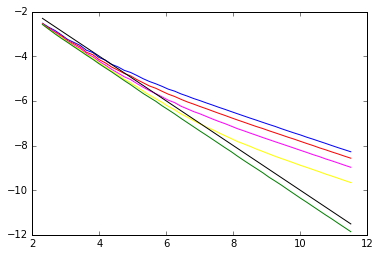

In [26]:
n = np.logspace(1, 5)
print(n)
#plt.plot(n, [1 / entropy_std(x, 0.5) for x in n], c='red')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.46)) for x in n], c='blue')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.47)) for x in n], c='red')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.48)) for x in n], c='magenta')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.49)) for x in n], c='yellow')
plt.plot(np.log(n), [np.log(entropy_std(x, 0.5)) for x in n], c='green')
plt.plot(np.log(n), -np.log(n), c='black')
#plt.plot(n, [1 / entropy_std(x, 0.3) for x in n], c='green')
#plt.plot(n, [1 / entropy_std(x, 0.2) for x in n], c='magenta')
#plt.semilogx(n, [entropy_std(x, 0.3) for x in n], c='blue')
#plt.semilogx(n, [entropy_std(x, 0.1) for x in n], c='magenta')
#plt.semilogx(n, [entropy_std(x, 0.05) for x in n], c='green')

In [27]:
from scipy.special import digamma, gamma, gammaln, beta, betaln, polygamma
from scipy.misc import derivative

### Multivariate beta function

In [28]:
def log_mvbeta(*alphas):
    return np.sum([gammaln(alpha) for alpha in alphas]) - gammaln(np.sum(alphas))

In [29]:
log_mvbeta(3, 4), betaln(3, 4)

(-4.0943445622221013, -4.0943445622221004)

### Beta function derivatives

In [1]:
# since beta(a, b) can be very small we use logarithms

def log_mbeta1(a, b):
    """ 
    ln(-beta'(a, b))
    """
    return betaln(a, b) + np.log(-digamma(a) + digamma(a + b))

def beta1(a, b):
    return -np.exp(log_mbeta1(a, b))

def log_beta2(a, b):
    """
    ln(beta"(a, b))
    """
    return betaln(a, b) + np.log((digamma(a) - digamma(a + b))**2 + (polygamma(1, a) - polygamma(1, a + b)))

def beta2(a, b):
    return np.exp(log_beta2(a, b))

In [2]:
def naive_beta1(a, b):
    return beta(a, b)*(digamma(a) - digamma(a + b))

In [3]:
beta1(1, 1), beta1(1, 1000), beta1(1000, 1000), beta1(0.5, 0.5), log_mbeta1(1000, 1000)

NameError: global name 'np' is not defined

In [4]:
b = 100
x = np.linspace(0, 1, 50)
plt.plot(x, -(beta(x, b) - beta(x + 0.01, b)) / 0.01)
plt.plot(x, beta1(x, b))

NameError: name 'np' is not defined

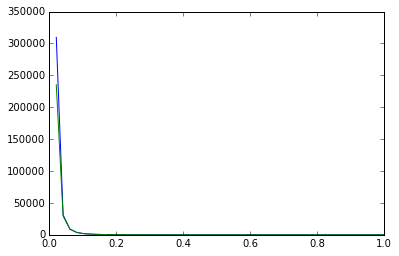

In [94]:
b = 100
x = np.linspace(0, 1, 50)
plt.plot(x, [derivative(lambda cx: beta(cx, b), x0, dx=0.01, n=2) for x0 in x])
plt.plot(x, beta2(x, b))

### Expectation of $p\,log(p)$

In [95]:
def log_mE_p_log_p(nx, ny):
    return log_mbeta1(nx + 1, ny) - betaln(nx, ny)

def E_p_log_p(nx, ny):
    return -np.exp(log_mE_p_log_p(nx, ny))

In [96]:
def empirical_E_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() 
        result += p * np.log(p)
    result /= n_iter
    
    return result

In [97]:
def analytic_E_p_log_p(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = factor.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        results.append(E_p_log_p(nx, ny))
    
    return np.asarray(results)

In [98]:
sorted(empirical_E_p_log_p(1000, ['DISCONNECT']))

[-0.21908505647565016, -0.10559412147312093]

In [99]:
sorted(analytic_E_p_log_p(1000, ['DISCONNECT']))

[-0.22980933397642248, -0.094774481468708399]

### Expectation of $p^2\,log^2(p)$

In [100]:
def log_E_p2_log_p2(nx, ny):
    return log_beta2(nx + 2, ny) - betaln(nx, ny)

def E_p2_log_p2(nx, ny):
    return np.exp(log_E_p2_log_p2(nx, ny))

In [101]:
def empirical_E_p2_log_p2(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        result += p**2 * np.log(p)**2
    result /= n_iter
    
    return result

In [102]:
def empirical2_E_p2_log_p2(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = np.zeros(factor.table.flatten().shape[0])
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        result += p**2 * np.log(p)**2
    result /= n_iter
    return result

In [103]:
def analytic_E_p2_log_p2(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = factor.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        results.append(E_p2_log_p2(nx, ny))
    
    return np.asarray(results)

In [104]:
sorted(analytic_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[7.6371285167352342e-05,
 0.0011289561749263347,
 0.0024065401883195023,
 0.0058819309338410449,
 0.014539735325870204,
 0.026236431661166591,
 0.060307180192899587,
 0.087629423055990502]

In [105]:
sorted(empirical2_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[0.00019438133854093948,
 0.0018743742079873889,
 0.0018793152019683655,
 0.0048986972403074437,
 0.014388159741895785,
 0.023094468162391666,
 0.052823961634092663,
 0.078780292189268339]

In [106]:
sorted(empirical_E_p2_log_p2(1000, ['DISCONNECT', 'VENTLUNG']))

[0.00081579555424875596,
 0.0029095097388009933,
 0.0037414469686712394,
 0.010578298168087584,
 0.022156680493787464,
 0.025924701651279115,
 0.060341473455305703,
 0.070519262874321809]

### Expectation of $p_i\,log(p_i)\,p_j\,log(p_j)$

In [107]:
def log_E_pi_log_pi_pj_log_pj(nx, ny, nz):
    if nz > 0.5:
        #return log_mbeta1(ny + 1, nz) + log_mbeta1(nx + 1, ny + nz + 1) - log_mvbeta(nx, ny, nz)
        return np.log(nx) + np.log(ny) + np.log(ny + nz) - np.log(ny + nz) - np.log(nx + ny + nz + 1) - \
            np.log(nx + ny + nz) + np.log(-(digamma(ny + 1) - digamma(ny + nz + 1))) + \
            np.log(-(digamma(nx + 1) - digamma(nx + ny + nz + 2)))
    else:
        dg_xy = digamma(nx + ny + 2)
        log_deriv = betaln(nx + 1, ny + 1) + np.log((digamma(nx + 1) - dg_xy)*(digamma(ny + 1) - dg_xy) - \
                                                   polygamma(1, nx + ny + 2))
        return log_deriv - betaln(nx, ny)

def E_pi_log_pi_pj_log_pj(nx, ny, nz):
    return np.exp(log_E_pi_log_pi_pj_log_pj(nx, ny, nz))

In [108]:
E_pi_log_pi_pj_log_pj(3, 100, 500), E_pi_log_pi_pj_log_pj(100, 3, 500)

(0.007580538813283055, 0.0073385042900296739)

In [109]:
from itertools import combinations
def empirical_E_pi_log_pi_pj_log_pj(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    m = factor.table.flatten().shape[0]
    result = np.zeros((m*(m - 1)) / 2)
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        
        current = []
        for pi, pj in combinations(p, 2):
            current.append(pi * pj * np.log(pi) * np.log(pj))
        result += np.asarray(current)
            
    result /= n_iter
    
    return result

In [110]:
def analytic_E_pi_log_pi_pj_log_pj(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    m = factor.table.flatten().shape[0]
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    p = factor.table.flatten() + 1e-5
    p = p / np.sum(p)
    
    result = []
    for pi, pj in combinations(p, 2):
        nx = int(pi*n)
        ny = int(pj*n)
        nz = n - nx - ny
        result.append(E_pi_log_pi_pj_log_pj(nx, ny, nz))
    result = np.asarray(result)
    return result

In [111]:
sorted(empirical_E_pi_log_pi_pj_log_pj(2000, ['HR']))

[0.013248329014952325, 0.017605365606538144, 0.046702613148114532]

In [112]:
sorted(analytic_E_pi_log_pi_pj_log_pj(2000, ['HR']))

[0.0043352663485512494, 0.0092568365861747364, 0.017811568706768744]

In [113]:
sorted(empirical_E_pi_log_pi_pj_log_pj(2000, ['DISCONNECT', 'FIO2']))

[0.0042127173240246139,
 0.0075020743702104067,
 0.0076434719336783028,
 0.01719806609078477,
 0.027200201752323322,
 0.029574234353000564]

In [114]:
sorted(analytic_E_pi_log_pi_pj_log_pj(2000, ['DISCONNECT', 'FIO2']))

[0.0034118318897573821,
 0.0036490968470340697,
 0.0058485178136283523,
 0.010954274137505471,
 0.013228619209686484,
 0.030501456017747831]

### Variance of p log p

In [55]:
def empirical_D_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    n_iter = 100
    for i in range(n_iter):
        data = factor.rvs(n)
        fact = gm.TableFactor(factor.arguments, factor.scope)
        fact.fit(data)
        p = fact.table.flatten() + 1e-5
        result.append(p * np.log(p))
        
    result = np.var(np.asarray(result), axis=0, ddof=1)
    
    return result

In [56]:
def analytic_D_p_log_p(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() * n
    
    for nx in counts:
        ny = n - nx
        nx = nx + 1
        ny = ny + 1
        results.append(E_p2_log_p2(nx, ny) - E_p_log_p(nx, ny)**2)
    
    return np.asarray(results)

In [57]:
def empirical2_D_p_log_p(n, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        result.append(p * np.log(p))
    result = np.var(result, axis=0, ddof=1)
    return result

In [58]:
sorted(analytic_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[4.9788594820697355e-05,
 7.724299530645351e-05,
 8.8090225199968786e-05,
 9.7225457673983068e-05,
 0.00012526698420523442,
 0.0001608527130417441,
 0.00018673675664925352,
 0.0001878774020219881]

In [59]:
sorted(empirical2_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[8.3062573822380412e-05,
 8.6368128298390545e-05,
 9.796677467645004e-05,
 0.00011985443378198883,
 0.00014860522376780456,
 0.00018560909653163955,
 0.00018816980646132022,
 nan]

In [60]:
sorted(empirical_D_p_log_p(1000, ['DISCONNECT', 'VENTLUNG']))

[0.00056830907734015438,
 0.00099535425754081674,
 0.0022269205847813929,
 0.0029053428841611245,
 0.0039750490110635793,
 0.0040533177304402992,
 0.0061516841389762612,
 0.0076899465887378298]

In [61]:
def entropy_stddev(n, variables):
    results = []
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    for i in range(100):
        data = factor.rvs(n)
        results.append(gm.information.discrete_entropy(data))
    return np.std(results)

In [62]:
def ed_entropy_stddev(n, variables):    
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    result = []
    data = factor.rvs(n)
    fact = gm.TableFactor(factor.arguments, factor.scope)
    fact.fit(data)
    counts = fact.table.flatten() + 1e-5
    counts = counts / np.sum(counts)
    counts = counts * n
    n_iter = 100000
    for i in range(n_iter):
        p = np.random.dirichlet(counts)
        result.append(np.sum(p * np.log(p)))
    result = np.std(result, axis=0, ddof=1)
    return result

In [87]:
from itertools import product, combinations
def analytic_entropy_stddev(N, variables):
    infer = gm.SumProductInference(true_dgm)
    factor = infer(query=variables)
    data = factor.rvs(N)
    fact = gm.TableFactor(factor.arguments, factor.scope).fit(data)
    counts = N * fact.table.flatten()
    
    result = 0.
    N = N + 3
    for nx, ny in combinations(counts, 2):
        nx = nx + 1
        ny = ny + 1
        
        #print 2*(E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny) - E_p_log_p(nx, N - nx)*E_p_log_p(ny, N - ny))
        #print E_p_log_p(nx, N - nx) 
        #print E_p_log_p(ny, N - ny)
        #print E_p_log_p(ny, N - ny) * E_p_log_p(nx, N - nx) 
        #print E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny)
        print
        result -= 2*(E_pi_log_pi_pj_log_pj(nx, ny, N - nx - ny) - \
                     E_p_log_p(nx, N - nx)*E_p_log_p(ny, N - ny))
    
    N = N - 1
    for nx in counts:
        nx = nx + 1
        result += E_p2_log_p2(nx, N - nx) - E_p_log_p(nx, N - nx)**2
        
    return np.sqrt(result)

In [88]:
entropy_stddev(100, ['VENTTUBE', 'VENTLUNG', 'DISCONNECT'])

ValueError: dims must have at least one value

In [86]:
analytic_entropy_stddev(100, ['VENTTUBE', 'VENTLUNG', 'DISCONNECT'])

ValueError: dims must have at least one value

In [66]:
ed_entropy_stddev(1000, ['VENTTUBE', 'VENTLUNG'])

nan

In [67]:
def analytic_entropy_variance(p, N):
    counts = N * p
    result = 0.
    N = N + 2
    for nx in counts:
        nx = nx + 1
        result += E_p2_log_p2(nx, N - nx) - E_p_log_p(nx, N - nx)**2
    return result

In [68]:
from graphmodels import TableFactor
def s_discrete_entropy(x):
    def make_factor(data, arguments, leak=1e-9):
        factor = TableFactor(arguments, list(data.columns))
        factor.fit(data)
        factor.table += leak
        factor.normalize(*factor.scope, copy=False)
        return factor
    arguments = list(x.columns)
    factor_x = make_factor(x, arguments).normalize(*arguments)
    prob = factor_x.table.flatten()
    variance = analytic_entropy_variance(prob, x.shape[0])
    return -np.sum(prob * np.log(prob)), variance

In [69]:
data = true_dgm.rvs(size=1000)[['ERRCAUTER', 'HRSAT']]
s_discrete_entropy(data)

(0.82719959391330244, 0.00065998492055703518)

In [70]:
class s_EntropyEstimator:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.cache = {}

    def _footprint(self, nodes, n):
        return tuple(nodes) + (n,)

    def __call__(self, nodes, n):
        fp = self._footprint(nodes, n)
        if fp in self.cache:
            return self.cache[fp]

        if np.any(nodes):
            subdata = self.data[self.data.columns[nodes]]

            result = s_discrete_entropy(subdata.iloc[:n])
        else:
            result = 0, 0

        self.cache[fp] = result
        return result


class s_InformationEstimator:
    def __init__(self, graph, data):
        self.graph = graph
        self.entropy_estimator = s_EntropyEstimator(graph, data)
        self.chosen = []

    def __call__(self, node, parents, N):
        parents = np.array(parents, dtype=bool)
        h1, v_h1 = self.entropy_estimator(parents, N)
        temp = np.zeros(len(parents), dtype=bool)
        temp[node] = True
        h2, v_h2 = self.entropy_estimator(temp, N)
        parents[node] = True
        h12, v_h12 = self.entropy_estimator(parents, N)
        return h1 + h2 - h12, v_h1 + v_h2 + v_h12


class s_ScoreBIC:
    def __init__(self, graph, data):
        self.graph = graph
        self.data = data
        self.n_values = np.asarray([len(self.data[column].value_counts()) for column in self.data.columns])
        self.mi_estimator = s_InformationEstimator(graph, data)

    def __call__(self, node, parents, N=None):
        parents = np.asarray(parents, dtype=bool)
        k = self.n_values[node]*np.prod(self.n_values[parents]) - 1
        n = self.data.shape[0]
        l, v_l = self.mi_estimator(node, parents, N=N)
        l *= n
        v_l *= n**2
        
        result = l - 0.5 * np.log(n) * k
        return result, v_l

    def total(self, N):
        score = 0.
        variance = 0.
        for node in self.graph.nodes():
            pa = self.graph.adj[:, node].copy()
            cs, cv = self(node, pa, N)
            score += cs
            variance += cv
        return score, variance

In [71]:
data = true_dgm.rvs(10000)
score = s_ScoreBIC(gm.MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns), data)

In [72]:
v = [False] * data.shape[1]
v[list(data.columns).index('ERRCAUTER')] = True

x, vx = score(list(data.columns).index('HRSAT'), v, 10000)
x, np.sqrt(vx)

(2096.9646924698641, 113.08053350989657)

In [73]:
from itertools import permutations
import networkx as nx
from graphmodels import DGM, MatrixGraph, InvalidOperation, LocalOperation
from graphmodels.information import get_eec, reset_eec
import matplotlib.pyplot as plt

class s_AddEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            raise InvalidOperation()
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 0
        return self

    def score(self, **kwargs):
        if self.graph.adj[self.src, self.dst]:
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 0
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 0
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var

        pa[self.src] = 1        
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var
        return score, score_v

    def __str__(self):
        return "s_AddEdge {}->{}".format(self.src, self.dst)
    

class s_RemoveEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        return self

    def score(self, **kwargs):
        if not self.graph.adj[self.src, self.dst]:
            return 0., 0.
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var
        
        pa[self.src] = 0
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var
        
        return score, score_v
    
    def __str__(self):
        return "s_RemoveEdge {}->{}".format(self.src, self.dst)


class s_ReverseEdge(LocalOperation):
    def __init__(self, graph, fscore, src, dst):
        LocalOperation.__init__(self, graph, fscore)
        self.src = src
        self.dst = dst

    def do(self):
        if not self.graph.adj[self.src, self.dst]:
            raise InvalidOperation()
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            raise InvalidOperation()
        return self

    def undo(self):
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        return self

    def score(self, **kwargs):
        if not self.graph.adj[self.src, self.dst]:
            return 0., 0.
        self.graph.adj[self.src, self.dst] = 0
        self.graph.adj[self.dst, self.src] = 1
        if not self.graph.is_acyclic():
            self.graph.adj[self.src, self.dst] = 1
            self.graph.adj[self.dst, self.src] = 0
            return 0., 0., 
        self.graph.adj[self.src, self.dst] = 1
        self.graph.adj[self.dst, self.src] = 0
        
        pa = self.graph.adj[:, self.dst].copy()
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score = -val
        score_v = var
        
        pa[self.src] = 0
        
        val, var = self.fscore(self.dst, pa, **kwargs)
        score += val
        score_v += var

        pa = self.graph.adj[:, self.src].copy()
        
        val, var = self.fscore(self.src, pa, **kwargs)
        score -= val
        score_v += var
        
        pa[self.dst] = 1
        
        val, var = self.fscore(self.src, pa, **kwargs)
        score += val
        score_v += var
        
        return score, score_v
    
    def __str__(self):
        return "s_ReverseEdge {}->{}".format(self.src, self.dst)


In [74]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'earthquake.bif'))
true_dgm.draw()

In [75]:
data = true_dgm.rvs(100000)
graph = MatrixGraph.from_networkx_DiGraph(true_dgm, order=data.columns)
graph.adj[:, :] = False
score = s_ScoreBIC(graph, data)
print data.columns

Index([u'Earthquake', u'Burglary', u'Alarm', u'MaryCalls', u'JohnCalls'], dtype='object')


In [76]:
ae = s_AddEdge(graph, score, 1, 4)
val, var = ae.score(N=100000)
var = np.sqrt(var)
val, var

(2061.8331484778128, 352.93869144515617)

In [77]:
def max_until_success(opx, opy, Nx, Ny, Nmax, Nbatch, k=3):
    #print "BEGIN COMPARSION"
    #print opx
    #print opy
    cx, vx = opx.score(N=Nx)
    cy, vy = opy.score(N=Ny)
    while Nx < Nmax or Ny < Nmax:
        #print "iteration:", Nx, Ny, cx, cy
        #print "mean:", cy - cx
        #print "k*stddev:", k*np.sqrt(vx + vy)
        
        if cy - cx > k*np.sqrt(vx + vy):
            return opy, Ny, Nx
        elif cx - cy > k*np.sqrt(vx + vy):
            return opx, Nx, Ny
        if Nx <= Ny:
            Nx += Nbatch
            cx, vx = opx.score(N=Nx)
        else:
            Ny += Nbatch
            cy, vy = opy.score(N=Ny)
    #print "warning: insufficient data
    if cx >= cy:
        return opx, Nx, Ny
    else:
        return opy, Ny, Nx

In [78]:
def probmax1(ops, Ninit, Nbatch, Nmax, k=3):
    best_op = ops[0]
    N_best = Ninit
    for i, op in enumerate(ops[1:]):
        best_op, N_best, _ = max_until_success(best_op, op, N_best, Ninit, Nmax, Nbatch, k=k)
    return best_op

In [79]:
class s_GreedySearch:
    def __init__(self, data, cls_score, Ninit=100, Nbatch=None, k=3):
        graph = nx.DiGraph()
        graph.add_nodes_from(data.columns)
        graph = MatrixGraph.from_networkx_DiGraph(graph, order=data.columns)
        self.graph = graph
        self.fscore = cls_score(graph, data)
        
        self.Ninit = Ninit
        self.Nbatch = Nbatch
        self.Nmax = data.shape[0]
        self.k = k

        self.ops = []
        self.ops += [s_AddEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [s_RemoveEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]
        self.ops += [s_ReverseEdge(graph, self.fscore, u, v) for u, v in permutations(graph.nodes(), 2)]

    def iteration(self):
        # plt.hist([op.score() for op in self.ops], bins=50)
        op = probmax1(self.ops, self.Ninit, self.Nbatch, self.Nmax, self.k)
        if op.score(N=self.Nmax)[0] <= 1e-5:
            return True
        try:
            op.do()
            return False
        except InvalidOperation:
            return True

    def __call__(self, max_iter=40, verbose=True):
        #reset_eec()
        counter = 0
        while not self.iteration() and counter < max_iter:
            if verbose:
                print(self.fscore.total(self.Nmax)[0])
                #print('entropy evaluations:', get_eec())
            counter += 1
        return DGM(self.graph.to_networkx_DiGraph())

In [80]:
from os import listdir
import os.path
NETWORKS_PATH = '/home/wrwt/Programming/pygraphmodels/networks/'
network_filenames = listdir(NETWORKS_PATH)
true_dgm = gm.DGM.read(os.path.join(NETWORKS_PATH, 'earthquake.bif'))
true_dgm.draw()

In [81]:
data = true_dgm.rvs(size=1000000)

In [82]:
from graphmodels import GreedySearch, ScoreBIC, AddEdge
gs = GreedySearch(data, ScoreBIC)

In [83]:
%%time
gs(max_iter=10).draw()

39360.5814934
entropy evaluations: 15
76350.9671013
entropy evaluations: 18
112404.349553
entropy evaluations: 20
133006.89744
entropy evaluations: 21
CPU times: user 5.54 s, sys: 88 ms, total: 5.63 s
Wall time: 5.63 s


In [386]:
from graphmodels import GreedySearch, ScoreBIC, AddEdge
gs = s_GreedySearch(data, s_ScoreBIC, Ninit=100, Nbatch=100000, k=1)

In [387]:
print data.columns

Index([u'Earthquake', u'Burglary', u'Alarm', u'MaryCalls', u'JohnCalls'], dtype='object')


In [388]:
%%time
gs(max_iter=1).draw()

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
40082.7452448
[[False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
[[False False False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]
CPU times: user 12.4 s, sys: 48 ms, total: 12.4 s
Wall time: 12.4 s


In [360]:
print [(lambda x: (x[0], np.sqrt(x[1])))(op.score(N=gs.Nmax)) for op in gs.ops]

[(-13.592238765881795, 965.87632957264407), (13721.645295137912, 1049.6109828901206), (6833.8724637899904, 1086.7229504116083), (5460.2486080265671, 1177.7749750309347), (-13.592238765881795, 1012.8101754762095), (40117.284021164916, 960.54529295010093), (20190.180925653105, 1028.9873529265285), (19960.289896963295, 1118.3578797741252), (13721.645295137912, 1063.3664933915702), (40117.284021164916, 926.73889319132786), (37252.128660514107, 1056.2211520842795), (36712.772001498633, 1147.007657676128), (6833.8724637899904, 1083.0598628865662), (20190.180925653105, 978.77448914848287), (37252.128660514107, 1038.5518445847952), (16161.84597963876, 1185.9508016823681), (5460.2486080265671, 1134.073521087088), (19960.289896963295, 1028.0203495822427), (36712.772001498633, 1088.8206199026108), (16161.84597963876, 1146.0350203149301), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0,

In [339]:
gs.Nmax

1000000

In [362]:
op = probmax1(gs.ops, gs.Ninit, gs.Nbatch, gs.Nmax, k=1)

In [363]:
str(op)

's_AddEdge 0->1'